# LTST Example with Exoplanetary Data

In [1]:
import random
random.seed(101)

In [2]:
# This example assumes the use of feather-format data. Note that
# instead of converting the input from a pandas dataframe to a
# numpy array, we work with the dataframe directly, and tack on
# the suffix .values as needed (as in the calls to the ltst functions).
import numpy as np
import pandas as pd
import feather
import random

# Data with 5 predictor variables and 1 response variable. This is a filtered
# version of data extracted from the Exoplanet Archive in Fall 2017.
# (https://exoplanetarchive.ipac.caltech.edu/)
# Predictors: pl_orbper (orbital period), pl_orbsmax (orbital semi-major axis length),
#             pl_bmassj (planetary mass), pl_orbeccen (orbital eccentricity),
#             pl_pnum (number of planets in system)
# Response: pl_discmethod (discovery method: Radial Velocity vs. Transit)
#
# Note: this is an academic example...we already know, e.g., that the transit method
#       is biased towards short-period exoplanets. Our results below simply confirm this.
data    = pd.read_feather('./planets.feather')
numTest = 234 # leaving 750 planets for training

# For these data, 63.1% are planets discovered via radial velocity, the rest via transits.
globalProportionClassZero = len(data.loc[data["pl_discmethod"]=="Radial Velocity"])/len(data)

# Pick test data (rows of data matrix)
idxTest = random.sample(range(len(data)),numTest)

# Set aside test data (and remove the response variable).
predTest = data.loc[idxTest,:]
predTest = predTest.loc[:,[False,True,True,True,True,True]]

# Define training variables (both predictor and response)
idxTrain  = np.setdiff1d(range(len(data)),idxTest)
varTrain  = data.loc[idxTrain,:]
predTrain = varTrain.loc[:,[False,True,True,True,True,True]]
respTrain = varTrain.loc[:,[True,False,False,False,False,False]]

# Convert the categorical response variable to numeric values.
#   Generates a warning because there are two possible values to the right of
#   the equals sign.
respTrain.loc[:,'pl_discmethod'] = respTrain.loc[:,'pl_discmethod'].cat.codes-7

# What is required from this code block: training predictor matrix and 
# response vector, and test predictor matrix.

/Users/peterfreeman/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:601: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item_labels[indexer[info_axis]]] = value


In [3]:
import ltst

trees     = ltst.ltst(predTrain.values,respTrain.values)
pred      = trees.predict(predTest.values)
test,pval = trees.test(pred,threshold=1-globalProportionClassZero)

__Visualization Example Using Boxplots__

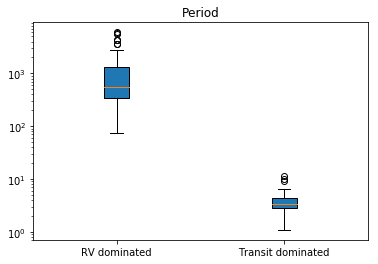

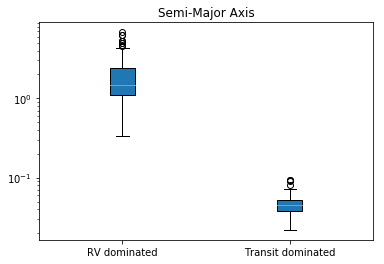

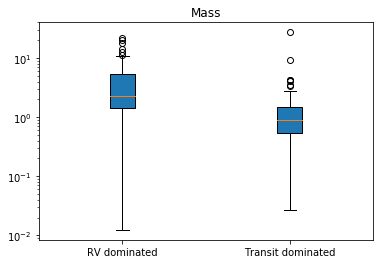

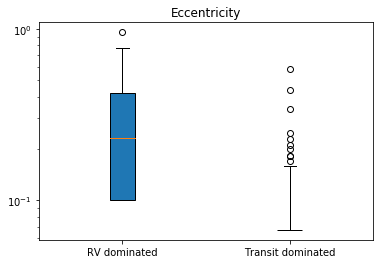

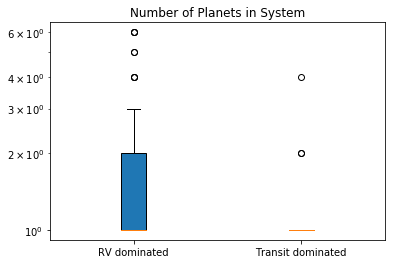

In [4]:
import matplotlib.pyplot as plt

sHi = np.where(test==1)[0]
sLo = np.where(test==0)[0]

title = ['Period','Semi-Major Axis','Mass','Eccentricity','Number of Planets in System'] 
for ii in range(5):
    plt.boxplot([predTest.values[sLo,ii],predTest.values[sHi,ii]],patch_artist=True,
                labels=['RV dominated','Transit dominated'])
    plt.yscale('log')
    plt.title(title[ii])
    plt.show()

__Visualization Example Using plotly__

Shows exoplanet mass vs. period. By hovering you can display the values of all five predictor variables.

In [5]:
from plotly.offline import plot
import plotly.graph_objs as go
import numpy as np

sFail = np.where(test==-1)[0]
sLo   = np.where(test==0)[0]
sHi   = np.where(test==1)[0]

traceFail = go.Scatter(
    x         = np.log10(predTest.values[sFail,0]),
    y         = np.log10(predTest.values[sFail,2]),
    name      = 'Not Sig.',
    text      = np.array([str(xx) for xx in predTest.values[sFail,:]]),
    hoverinfo = 'text',
    mode      = 'markers',
    marker    = dict(
        size  = 5,
        color = 'green'
    )
)
traceLo = go.Scatter(
    x         = np.log10(predTest.values[sLo,0]),
    y         = np.log10(predTest.values[sLo,2]),
    name      = 'RV Dom.',
    text      = np.array([str(xx) for xx in predTest.values[sLo,:]]),
    hoverinfo = 'text',
    mode      = 'markers',
    marker    = dict(
        size  = 10,
        color = 'red'
    )
)
traceHi = go.Scatter(
    x         = np.log10(predTest.values[sHi,0]),
    y         = np.log10(predTest.values[sHi,2]),
    name      = 'Transit Dom.',
    text      = np.array([str(xx) for xx in predTest.values[sHi,:]]),
    hoverinfo = 'text',
    mode      = 'markers',
    marker    = dict(
        size  = 10,
        color = 'blue'
    )
)

data = [traceFail,traceLo,traceHi]

layout = go.Layout(
    hovermode = 'closest',
    xaxis = dict(
        title    = 'Log10(Period in Days)',
        zeroline = False
    ),
    yaxis = dict(
        title    = 'Log10(Jupiter Masses)',
        zeroline = False
    )
)

fig = go.Figure(data=data,layout=layout)
plot(fig,filename='exoplanet-scatter.html')

'file:///Users/peterfreeman/Dropbox/R2Python/pef_python/exoplanet-scatter.html'

__Visualization Example Using tSNE__

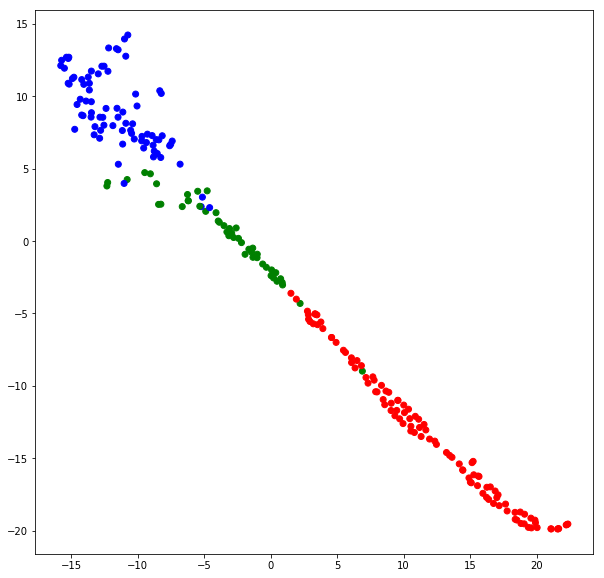

In [6]:
import matplotlib.pyplot as plt
from sklearn import manifold

nrow = np.shape(predTest.values)[0]
color = ['green']*nrow
for ii in range(nrow):
    if test[ii] == 0   : color[ii] = 'red'
    elif test[ii] == 1 : color[ii] = 'blue'

tsne = manifold.TSNE()
Y = tsne.fit_transform(predTest.values)

plt.figure(figsize=(10,10))
plt.scatter(Y[:,0],Y[:,1],c=color)
plt.show()